Training data shape: X=(192, 1), y=(192, 1)


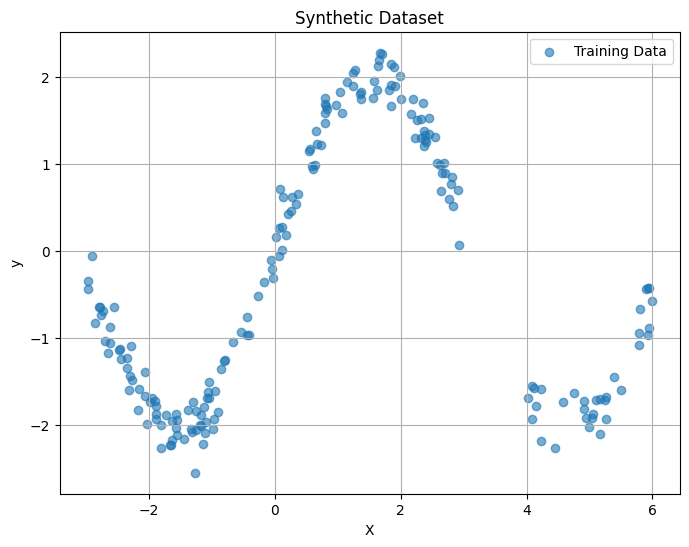

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Function to generate synthetic data
def generate_data(n_samples=100, noise_std=0.1):
    np.random.seed(42)
    X = np.random.uniform(-3., 3., size=(n_samples, 1)).astype(np.float32)
    # A simple non-linear function + noise
    y = np.sin(X[:, 0]) * 2 + np.random.normal(0, noise_std, size=n_samples).astype(np.float32)
    # Add some outlier regions with less data
    X_outlier = np.random.uniform(4., 6., size=(n_samples // 5, 1)).astype(np.float32)
    y_outlier = np.sin(X_outlier[:, 0]) * 2 + np.random.normal(0, noise_std, size=n_samples // 5).astype(np.float32)
    X = np.vstack((X, X_outlier))
    y = np.hstack((y, y_outlier))

    # Reshape y for consistency
    y = y.reshape(-1, 1)

    return X, y

# Generate data
N_SAMPLES = 200
NOISE_STD = 0.2
X_data, y_data = generate_data(N_SAMPLES, NOISE_STD)

# Split data (optional, but good practice)
X_train, X_test_dummy, y_train, y_test_dummy = train_test_split(
    X_data, y_data, test_size=0.2, random_state=43
)

print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")

# Plot the generated data
plt.figure(figsize=(8, 6))
plt.scatter(X_train, y_train, alpha=0.6, label='Training Data')
plt.title('Synthetic Dataset')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

# For reproducibility
tf.random.set_seed(42)

# Define the prior and posterior distributions for the weights
# We use a simple standard Normal prior and a learnable Normal posterior (Mean Field approximation)
def prior_fn(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return tfk.Sequential([
        tfpl.VariableLayer(n, dtype=dtype),
        tfpl.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=tf.zeros(n, dtype=dtype), scale=1),
            reinterpreted_batch_ndims=1)),
    ])

def posterior_fn(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return tfk.Sequential([
        tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n), dtype=dtype),
        tfpl.IndependentNormal(n),
    ])

# Define the KL divergence loss scaling factor (important!)
# Usually scaled by the number of examples in the dataset
kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) / tf.cast(X_train.shape[0], dtype=tf.float32))


# --- Build the BNN Model ---
hidden_units = 32
model = tfk.Sequential([
    tfkl.InputLayer(input_shape=(1,)), # Input dimension is 1
    tfpl.DenseVariational(
        units=hidden_units,
        make_prior_fn=prior_fn,
        make_posterior_fn=posterior_fn,
        kl_weight=1.0 / X_train.shape[0], # Alternative way to scale KL div
        # kl_use_exact=False, # Use analytic KL div if possible (default for Normal)
        activation='relu',
        name='dense_variational_1'
    ),
    tfpl.DenseVariational(
        units=hidden_units // 2,
        make_prior_fn=prior_fn,
        make_posterior_fn=posterior_fn,
        kl_weight=1.0 / X_train.shape[0],
        activation='relu',
        name='dense_variational_2'
    ),
    # Output layer: Predicts mean AND standard deviation for a Normal distribution
    # We predict 2 values: loc (mean) and scale_parameter (softplus applied later)
    tfpl.DenseVariational(
        units=tfpl.IndependentNormal.params_size(1), # Params for mean and scale of 1 output dim
        make_prior_fn=prior_fn,
        make_posterior_fn=posterior_fn,
        kl_weight=1.0 / X_train.shape[0],
        name='dense_variational_output'
    ),
    # Create the output distribution (IndependentNormal)
    # It takes the params from the last layer and creates a Normal distribution
    # We apply softplus to the scale parameter to ensure it's positive
    tfpl.IndependentNormal(
        event_shape=(1,), # Predict a single value
        convert_to_tensor_fn=lambda s: tfd.Normal(loc=s[..., :1], scale=1e-3 + tf.nn.softplus(s[..., 1:])),
        name='output_distribution'
        )
])

# Define the negative log-likelihood loss function
# This measures how well the predicted distribution matches the target values
def negative_log_likelihood(y_true, y_pred_dist):
    return -y_pred_dist.log_prob(y_true)

# Compile the model
# The total loss = NLL + KL divergence (KL is added automatically by DenseVariational layers)
model.compile(optimizer=tfk.optimizers.Adam(learning_rate=0.01),
              loss=negative_log_likelihood,
              metrics=[tfk.metrics.RootMeanSquaredError()])

model.summary()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Function to generate synthetic data
def generate_data(n_samples=100, noise_std=0.1):
    np.random.seed(42)
    X = np.random.uniform(-3., 3., size=(n_samples, 1)).astype(np.float32)
    # A simple non-linear function + noise
    y = np.sin(X[:, 0]) * 2 + np.random.normal(0, noise_std, size=n_samples).astype(np.float32)
    # Add some outlier regions with less data
    X_outlier = np.random.uniform(4., 6., size=(n_samples // 5, 1)).astype(np.float32)
    y_outlier = np.sin(X_outlier[:, 0]) * 2 + np.random.normal(0, noise_std, size=n_samples // 5).astype(np.float32)
    X = np.vstack((X, X_outlier))
    y = np.hstack((y, y_outlier))

    # Reshape y for consistency
    y = y.reshape(-1, 1)

    return X, y

# Generate data
N_SAMPLES = 200
NOISE_STD = 0.2
X_data, y_data = generate_data(N_SAMPLES, NOISE_STD)

# Split data (optional, but good practice)
X_train, X_test_dummy, y_train, y_test_dummy = train_test_split(
    X_data, y_data, test_size=0.2, random_state=43
)

print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")

# Plot the generated data
plt.figure(figsize=(8, 6))
plt.scatter(X_train, y_train, alpha=0.6, label='Training Data')
plt.title('Synthetic Dataset')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()
Use code with caution.
Python
3. Designing the Bayesian Neural Network
We'll use TFP's DenseVariational layer. This layer replaces deterministic weights with distributions (typically Normal distributions parameterized by learned means and standard deviations). We use variational inference, where we learn an approximation (the variational posterior) to the true Bayesian posterior distribution over the weights.
import tensorflow as tf
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

# For reproducibility
tf.random.set_seed(42)

# Define the prior and posterior distributions for the weights
# We use a simple standard Normal prior and a learnable Normal posterior (Mean Field approximation)
def prior_fn(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return tfk.Sequential([
        tfpl.VariableLayer(n, dtype=dtype),
        tfpl.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=tf.zeros(n, dtype=dtype), scale=1),
            reinterpreted_batch_ndims=1)),
    ])

def posterior_fn(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return tfk.Sequential([
        tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n), dtype=dtype),
        tfpl.IndependentNormal(n),
    ])

# Define the KL divergence loss scaling factor (important!)
# Usually scaled by the number of examples in the dataset
kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) / tf.cast(X_train.shape[0], dtype=tf.float32))


# --- Build the BNN Model ---
hidden_units = 32
model = tfk.Sequential([
    tfkl.InputLayer(input_shape=(1,)), # Input dimension is 1
    tfpl.DenseVariational(
        units=hidden_units,
        make_prior_fn=prior_fn,
        make_posterior_fn=posterior_fn,
        kl_weight=1.0 / X_train.shape[0], # Alternative way to scale KL div
        # kl_use_exact=False, # Use analytic KL div if possible (default for Normal)
        activation='relu',
        name='dense_variational_1'
    ),
    tfpl.DenseVariational(
        units=hidden_units // 2,
        make_prior_fn=prior_fn,
        make_posterior_fn=posterior_fn,
        kl_weight=1.0 / X_train.shape[0],
        activation='relu',
        name='dense_variational_2'
    ),
    # Output layer: Predicts mean AND standard deviation for a Normal distribution
    # We predict 2 values: loc (mean) and scale_parameter (softplus applied later)
    tfpl.DenseVariational(
        units=tfpl.IndependentNormal.params_size(1), # Params for mean and scale of 1 output dim
        make_prior_fn=prior_fn,
        make_posterior_fn=posterior_fn,
        kl_weight=1.0 / X_train.shape[0],
        name='dense_variational_output'
    ),
    # Create the output distribution (IndependentNormal)
    # It takes the params from the last layer and creates a Normal distribution
    # We apply softplus to the scale parameter to ensure it's positive
    tfpl.IndependentNormal(
        event_shape=(1,), # Predict a single value
        convert_to_tensor_fn=lambda s: tfd.Normal(loc=s[..., :1], scale=1e-3 + tf.nn.softplus(s[..., 1:])),
        name='output_distribution'
        )
])

# Define the negative log-likelihood loss function
# This measures how well the predicted distribution matches the target values
def negative_log_likelihood(y_true, y_pred_dist):
    return -y_pred_dist.log_prob(y_true)

# Compile the model
# The total loss = NLL + KL divergence (KL is added automatically by DenseVariational layers)
model.compile(optimizer=tfk.optimizers.Adam(learning_rate=0.01),
              loss=negative_log_likelihood,
              metrics=[tfk.metrics.RootMeanSquaredError()])

model.summary()
Use code with caution.
Python
Explanation of the Design:
DenseVariational Layers: These replace standard Dense layers. They maintain distributions over weights and biases.
prior_fn, posterior_fn: Define the prior belief about weights (Standard Normal) and the form of the approximate posterior we want to learn (also Normal, but with learnable mean and stddev). This is a common setup called Mean-Field Variational Inference.
kl_weight / kl_divergence_function: The KL divergence term in the loss function penalizes the model if the learned posterior deviates too far from the prior. It needs to be scaled relative to the data likelihood term (NLL). Dividing by the number of training samples (X_train.shape[0]) is a standard approach.
Output Layer for Regression: Instead of just predicting a single value, the BNN predicts the parameters of a probability distribution (here, a Normal distribution: its mean loc and standard deviation scale). This allows the model to express aleatoric uncertainty (inherent noise in the data).
IndependentNormal Layer: This TFP layer takes the parameters output by the last DenseVariational layer and constructs the final predictive Normal distribution. We ensure the predicted standard deviation (scale) is positive using tf.nn.softplus.
Loss Function (negative_log_likelihood): We use the NLL of the predicted distribution evaluated at the true target values. This, combined with the KL divergence automatically added by the DenseVariational layers, forms the Evidence Lower Bound (ELBO), which we maximize (or minimize the negative ELBO).
4. Training the BNN
print("Starting training...")
history = model.fit(X_train, y_train,
                    epochs=500,
                    batch_size=32,
                    verbose=0, # Set to 1 or 2 for more verbose output
                    validation_split=0.2) # Use part of training data for validation during training
print("Training finished.")

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss (NLL + KL)')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()